In [3]:
import os
import re

import matplotlib.pyplot as plt
from create_entropy_score import EntropyTypes
from utils.evaluations_utils import *
import numpy as np
%matplotlib inline
import matplotlib
import seaborn as sn
import re


<h3> add parameters<h3>

In [26]:
#{tag:plot name}
# models = {'davids_ergodic_train':'NMDA','reduction_ergodic_train':'reduction','train_AMPA_gmax1':'AMPA gmax 0.0004','train_AMPA_gmax2':'AMPA gmax 0.0008','train_AMPA_gmax3':'AMPA gmax 0.0012','train_AMPA_gmax4':'AMPA gmax 0.0016'}
# name_order = ['NMDA','reduction','AMPA gmax 0.0004','AMPA gmax 0.0008','AMPA gmax 0.0012','AMPA gmax 0.0016']
# file_dest = "small_eval_fnum30000_seed_1623324578916768431.pkl"
# models={'Rat_L5b_PC_2_Hay_0-6_DSEN':'L5PC 0.6','Rat_L5b_PC_2_Hay_0-4_DSEN':'L5PC 0.4','Rat_L5b_PC_2_Hay_0-8_DSEN':'L5PC 0.8','Rat_L5b_PC_2_Hay_1_DSEN':'L5PC 1'}
models={}
regex_match = re.compile('Rat.+SCALE_500')
gmax_regex = re.compile('.*_([0-9](?:-[0-9])?)_.*')

for i in os.listdir('entropy_data'):
    if regex_match.match(i):
        models[i] = gmax_regex.match(i).group(1).replace('-','.')
# models = {f'Rat_L5b_PC_2_Hay_{str(np.around(i*0.2,1)).replace(".","-").replace("-0","")}_DSEN_TS500':f'L5PC {str(np.around(i*0.2,1)).replace(".0","")}' for i in range(2,11)}

# models={'Rat_L5b_PC_2_Hay_0-6_DSEN_TS500':'L5PC 0.6','Rat_L5b_PC_2_Hay_0-4_DSEN_TS500':'L5PC 0.4',
#         'Rat_L5b_PC_2_Hay_0-8_DSEN_TS500':'L5PC 0.8'}
name_order = list(models.values())
name_order = sorted(name_order,key=lambda x:float(x))
remove_v = True
eval_name= 'L5bPC_test_SCALE_500'
# models
# name_order

In [27]:
name_order

['0.4', '0.6', '0.8', '1', '1.2', '1.4', '1.6']

loading model

In [28]:
# with open(os.path.join('entropy_data',file_dest),'rb') as f:
#     d_dict = pickle.load(f)
# print(d_dict.keys())
d = ModelsSEData(tags=list(models.keys()),is_folder=True)
# d = ModelsSEData(data_dict=d_dict)
# d.sample_from_set(d_ratio)
df, m_names = d.get_as_dataframe()
models = {k:v for k,v in models.items()}
# for i in models.keys():
    # df[df['model']==i]['model'] = models[i]
# models = {v:v for v in models.values()}
df.replace(inplace=True,to_replace=models)
if remove_v:
    v_columns_to_remove=[]
    for i in df.columns:
        if '_v_'in i:
            v_columns_to_remove.append(i)
    print(v_columns_to_remove)
    df = df.drop(columns=v_columns_to_remove)

100%|██████████| 7/7 [00:00<00:00, 21.12it/s]
455it [00:00, 56838.47it/s]

['DISCRETE_SAMPLE_ENTROPY_v_MSx', 'DISCRETE_SAMPLE_ENTROPY_v_A', 'DISCRETE_SAMPLE_ENTROPY_v_template_debugging', 'DISCRETE_SAMPLE_ENTROPY_v_CI']


Drop Nones and inf columns

In [17]:
print([len(d.data[i]) for i in d.data.keys()])
print(len(d.keys))

[65, 65, 65, 65, 65, 65, 65]
65


In [29]:
inf_nan_columns = []
for i in df.columns:
    dfinf = df[i]
    if 'ENTROPY' not in i:
        continue
    if dfinf.dtype == object:
        dfinf = np.array(list(dfinf))

    if np.any(np.isinf(dfinf)):
        inf_nan_columns.append(i)
print(inf_nan_columns)
df.drop(inf_nan_columns, axis=1, inplace=True)


[]


<h2> Distributions visualization over the CI <h2>

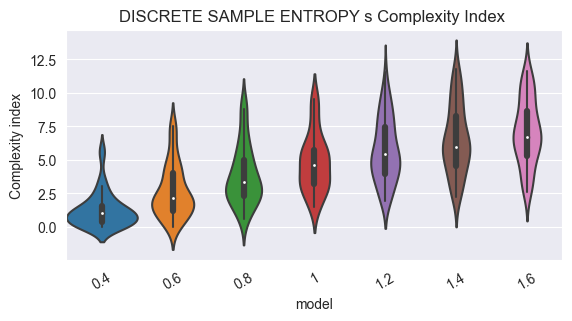

In [30]:
box_plot_data = {}
colors_index={}
c_obj=set()
temp_df= d
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            c_obj.add(c)

for c in c_obj:
    fig, ax = plt.subplots()
    bpa=[]
    keylen = len(box_plot_data)
    c_arr=[]
    i=0
    r = sn.violinplot(data=df,y=c,x='model',width=1.,orient='v', order=name_order)

    r.set_xticklabels(r.get_xticklabels(),rotation=30)
    ax.set_ylabel('Complexity index')

    ax.set_title(f'{c.replace("CI","").replace("_"," ")}Complexity Index ')
    plt.subplots_adjust(bottom=0.4)

    fig
    save_large_plot(fig, f"boxplot{c}_{len(d)}.png", tags=eval_name)


hist plot of the cis


100%|██████████| 10/10 [00:00<00:00, 75.95it/s]


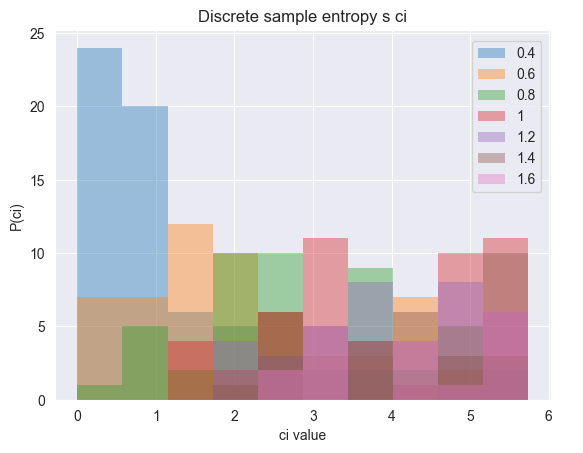

In [31]:
for c in tqdm(df.columns):
    if not ('ENTROPY' in c and 'CI' in c):
        continue
    df = df.sort_values(['key'])
    datas = []
    ci_data = []
    for i in name_order:
        ci_data.append(np.vstack(df[df['model'] == i][c].tolist()))
    dist = []
    bins = 10
    # all_data= np.vstack(datas)
    fig, ax = plt.subplots()
    for j, n in enumerate(name_order):
        if np.any(np.isnan(ci_data[j])):
            print(n)
        frequency, bins = np.histogram(ci_data[j][~np.isnan(ci_data[j])], bins=bins)
        # print(frequency)
        # frequency = frequency / np.sum(frequency)
        ax.stairs(frequency, bins, fill=True, label=n, alpha=0.4)
    fig.legend(loc=1, borderaxespad=3)
    ax.set_title(c.lower().replace('_', ' ').capitalize())
    ax.set_ylabel('P(ci)')
    ax.set_xlabel('ci value')
    save_large_plot(fig,f'dist_1d_{c}_{len(d)}.png',tags=eval_name)
    fig

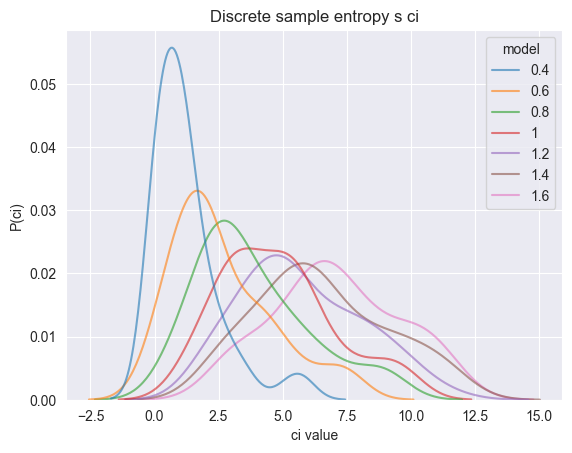

In [32]:
name_order_dict= {n:i for i,n in enumerate(name_order)}
df = df.sort_values(['model'],key = lambda x: [name_order_dict[i] for i in x])

for c in (df.columns):
    if not ('ENTROPY' in c and 'CI' in c):
        continue
    fig, ax = plt.subplots()
    res = sn.kdeplot(data=df,x = f'{c}', shade=False,hue='model',alpha=0.6)#thresh
    # for i in models.keys():
        # print(np.std(df[df['model'==i]][c]),c,i)
    ax.set_title(c.lower().replace('_', ' ').capitalize())
    ax.set_ylabel('P(ci)')
    ax.set_xlabel('ci value')
    # ax.set_yscale('log')

    save_large_plot(fig,f'dist_1d_{c}_{len(d)}.png',tags=eval_name)
    fig

In [33]:
box_plot_data = {}
colors_index={}
c_obj=set()
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            c_obj.add(c[:-len('_s_CI')])
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            if c not in box_plot_data:
                box_plot_data[c]=[]
            box_plot_data[c].append(df[df['model'] == m][c].tolist())
            box_plot_data[c][-1] = np.array(box_plot_data[c][-1])
for c in tqdm(c_obj):
    # for i,m in enumerate(name_order):
    res = sn.kdeplot(data=df,y = f'{c}_v_CI',x =f'{c}_s_CI', shade=False,hue='model',alpha=0.6)#thresh
    plt.ylabel('v')
    plt.xlabel('s')
    plt.title(c.lower().replace('_',' ').capitalize())
    save_large_plot(plt,f'kde{c}_{len(d)}.png',tags=eval_name)
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: Could not interpret value `DISCRETE_SAMPLE_ENTROPY_v_CI` for parameter `y`


<h4> norm sorted <h4>

100%|██████████| 7/7 [00:00<00:00, 1404.19it/s]
C:\Users\ninit\AppData\Local\Temp\ipykernel_15352\1598070061.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


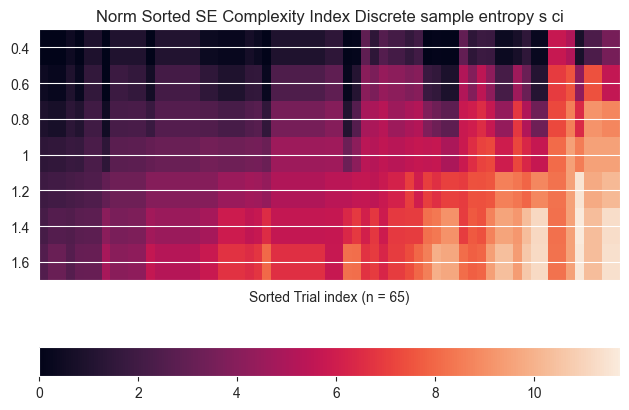

In [34]:
df = df.sort_values(['key'])
box_plot_data = {}
colors_index={}
c_obj=set()
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            c_obj.add(c)
for c in c_obj:
    diff_vec = []
    for j in tqdm(name_order):
        # a = df[(df['model'] == j)][c].values
        diff_vec.append(df[(df['model'] == j)][c].values)
    diff_vec = np.array(diff_vec)
    temp_diff_vec = diff_vec.copy()
    a = np.argsort(np.linalg.norm(diff_vec, axis=0))
    fig, ax = plt.subplots()
    mat = diff_vec[:, a]
    im = ax.matshow(mat)
    ax.set_aspect(mat.shape[1]//(mat.shape[0]*2))
    ax.set_xticks([])
    ax.set_xlabel(f'Sorted Trial index (n = {diff_vec.shape[1]:,})')
    ax.set_yticks(range(len(name_order)), name_order)
    ax.set_title(f'Norm Sorted SE Complexity Index {c.lower().replace("_"," ").capitalize()}')
    fig.colorbar(im, location="bottom")
    plt.tight_layout()
    save_large_plot(fig, f'norm_wise_orderd_matrix{c}_{len(d)}.png', eval_name)

    fig.show()

<h4> spike count per simulation <h4>

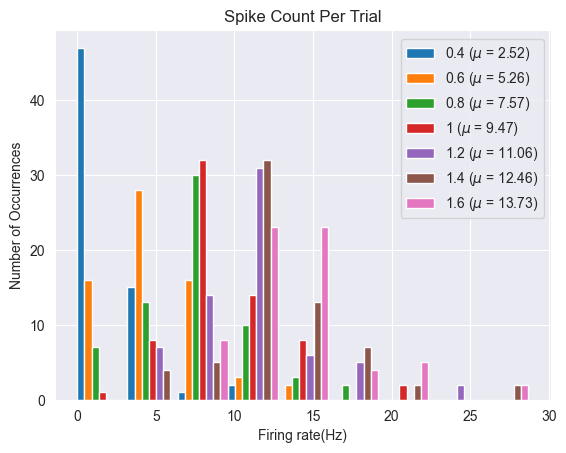

In [45]:

#spike_count
fig, ax = plt.subplots()
datas = []
for i in name_order:
    datas.append(np.array(df[df['model'] == i]['spikes'].tolist()))
    d_size=datas[-1].shape[1]
    datas[-1]=datas[-1].sum(axis=1)
    datas[-1]=datas[-1]*1000/d_size
    # a=np.mean(np.array(datas[-1]),axis=1)
    # print(i, np.mean(np.array(datas[-1]),axis=1))
names_for_plots_labels = [(mn + f" ($\mu$ = {np.round(np.mean(np.array(datas[i])), 2)})") for i, mn in
                          enumerate(name_order)]
d_arr=np.vstack(datas)
bins = np.linspace(np.min(d_arr),np.max(d_arr),10)


ax.hist(datas, bins=bins,rwidth=1, label=names_for_plots_labels, alpha=1, align='mid')
ax.set_title('Spike Count Per Trial')
# ax.set_yscale('log')
ax.set_xlabel('Firing rate(Hz)')
ax.set_ylabel('Number of Occurrences')
# ax.set_xticks(bins[::5] - 0.5, bins[::5])
fig.legend(bbox_to_anchor=[0.9, 0.875])
# save_large_plot(fig, 'spike_count.png', name_order)
save_large_plot(fig,f'spike_count_{len(d)}.png',tags=eval_name)




distributions

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ninit\AppData\Local\Temp\ipykernel_15352\435324296.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


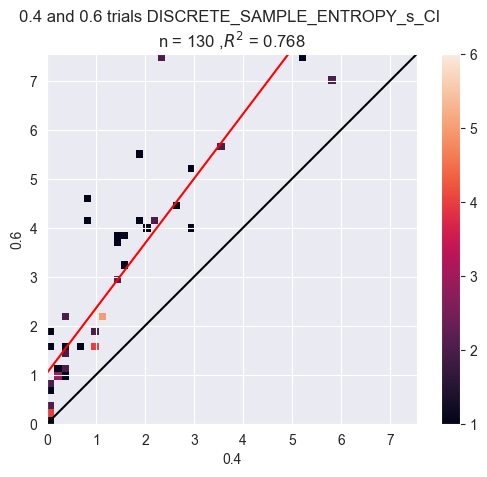

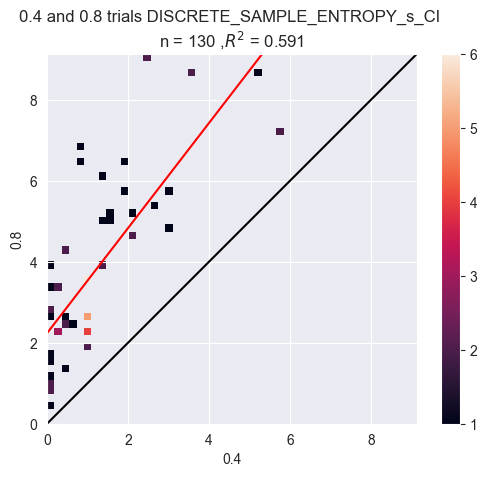

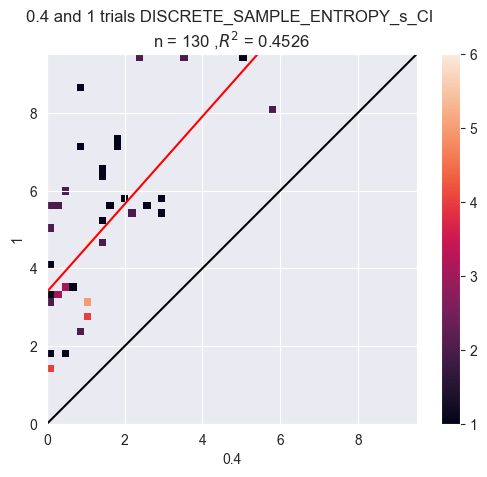

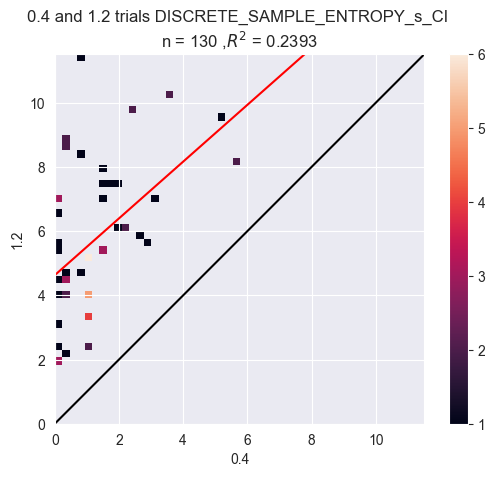

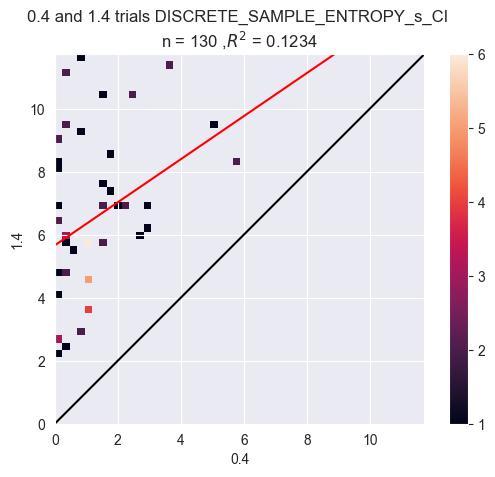

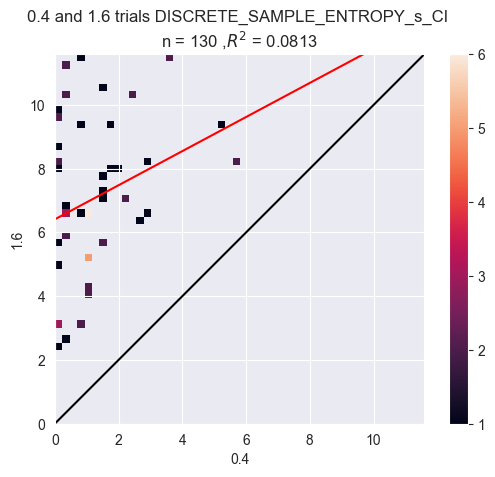

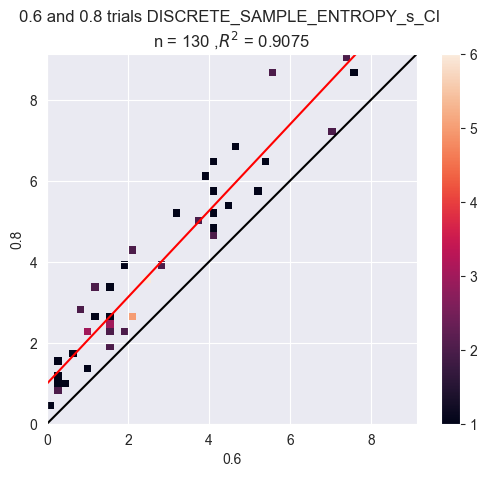

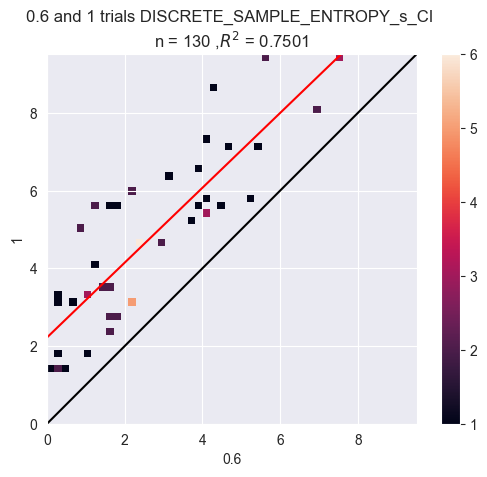

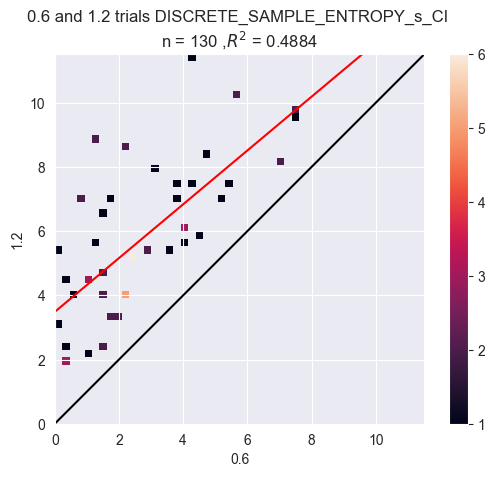

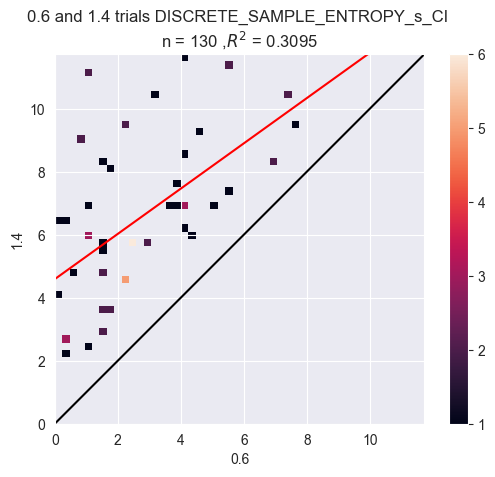

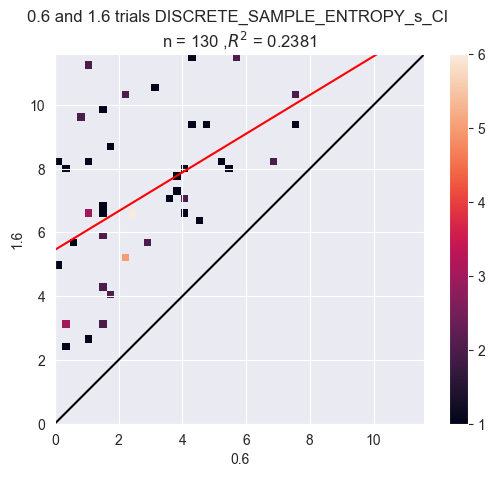

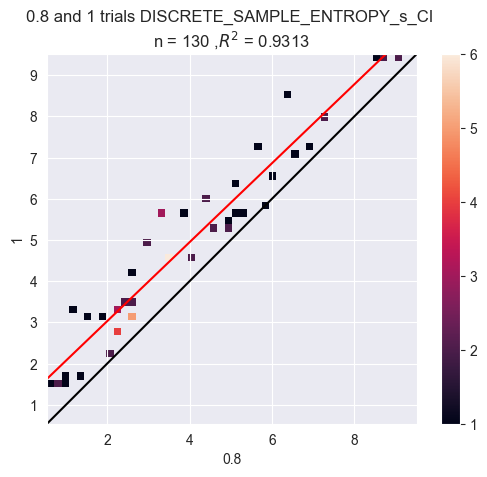

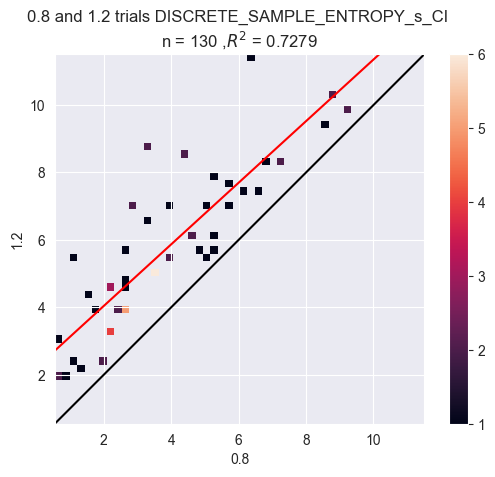

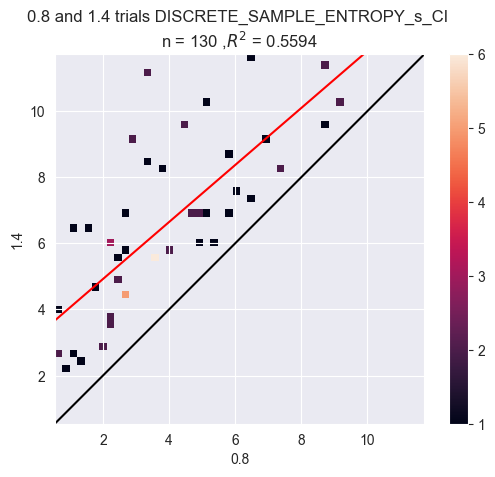

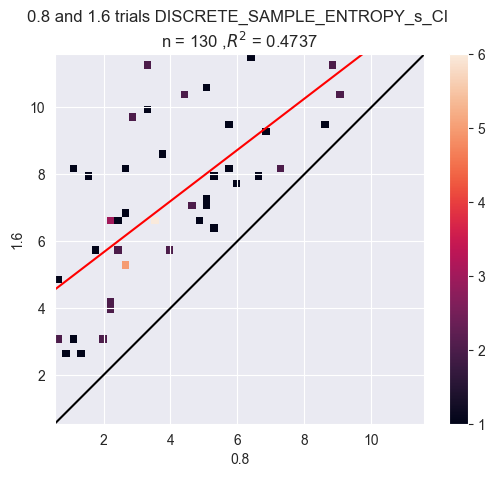

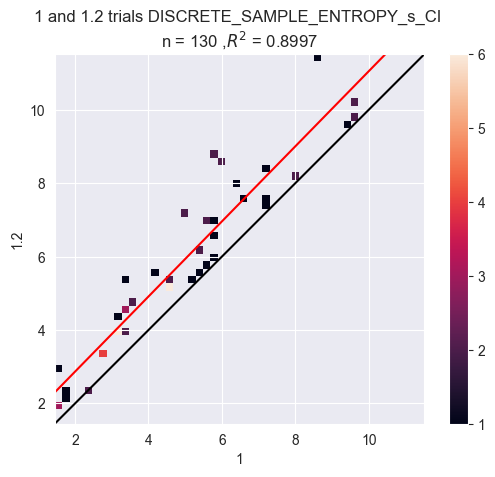

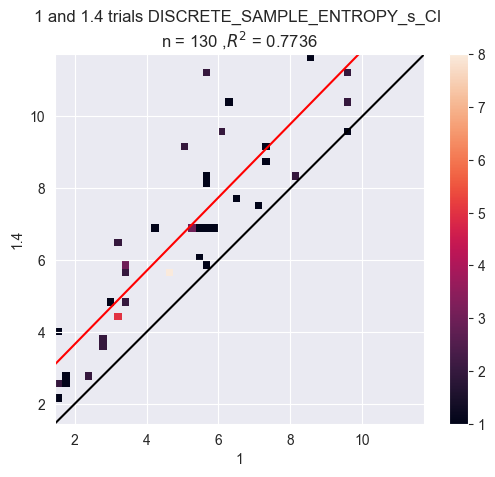

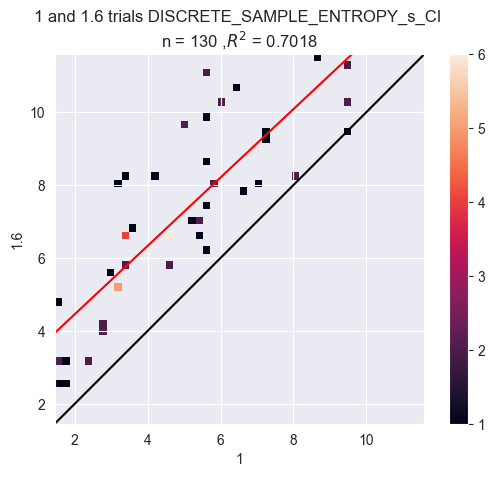

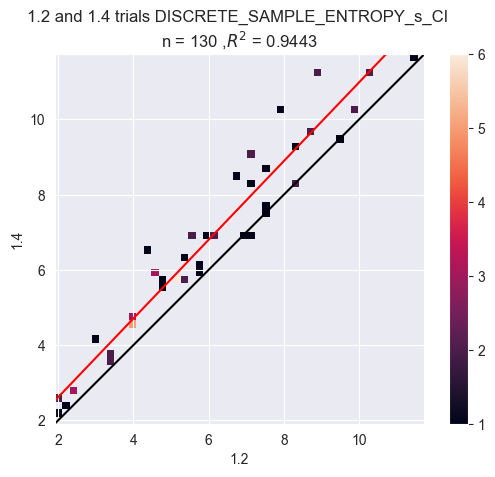

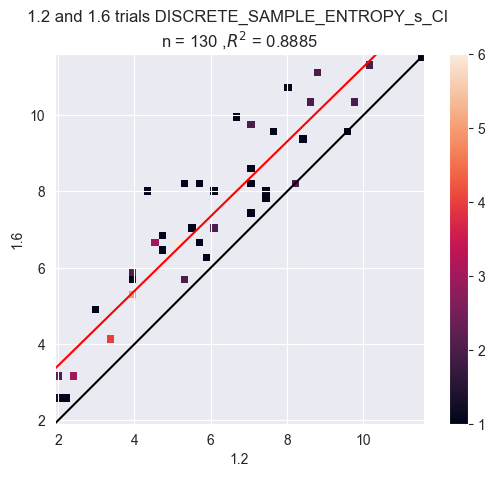

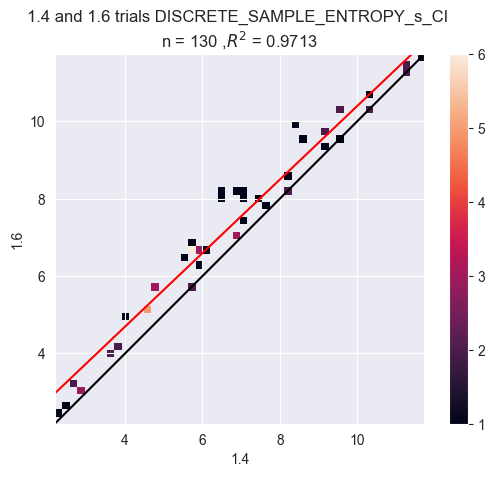

In [46]:

for i in tqdm(df.columns):
    if not ('ENTROPY' in i and 'CI' in i):
        continue
    datas=[]
    df = df.sort_values(by=['key'])
    prev_index=None
    indexes=None
    for m in name_order:
        prev_index=indexes
        indexes=df[df['model'] == m]['key'].tolist()
        datas.append(np.hstack(df[df['model'] == m][i].tolist()))
        if prev_index is not None:
            assert all(i==j for i,j in zip(prev_index,indexes)),'\n'.join([('' if i==j else str((i,j)))for i,j in zip(prev_index,indexes)])
        # datas.append(np.vstack(df[df['model'] == m][i].tolist()).sum(axis=1))
    for j in combination_sorting(name_order):
        first_index, second_index = j[0],j[1]
        fig, ax = plt.subplots()
        nans = np.logical_or(np.isnan(datas[first_index]),np.isnan(datas[second_index]))
        lims = (np.min(np.vstack((datas[first_index][~nans], datas[second_index][~nans]))),
                np.max(np.vstack((datas[first_index][~nans], datas[second_index][~nans]))))
        H, xedges, yedges = np.histogram2d(datas[first_index][~nans], datas[second_index][~nans], range=np.array([lims, lims]),
                                           bins=50)
        # replace zeroes with nan
        H[H == 0] = np.nan
        im = ax.imshow(H.T, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
                       )
        # , norm=colors.LogNorm())
        ax.plot(lims, lims, color='black')
        slope, intercept, r_value, p_value, std_err = linregress(np.array(datas[first_index]), datas[second_index])
        reg_intercep = intercept
        reg_coef = slope
        x = lims
        y = [reg_intercep + lims[0] * reg_coef, reg_intercep + lims[1] * reg_coef]
        ax.plot(x, y, color='red')
        fig.colorbar(im)
        ax.set_xlabel(name_order[first_index])
        ax.set_ylabel(name_order[second_index])
        ax.set_ylim(lims)
        ax.set_xlim(lims)
        ax.set_title(
            f"{name_order[first_index]} and {name_order[second_index]} trials {i} \nn = {len(datas[second_index]) * 2:,} ,$R^2$ = {np.round(r_value ** 2, 4)}")
        fig
        save_large_plot(fig, f"pairwise_2dhist_{i}_{name_order[first_index]}_{name_order[second_index]}_{len(d)}.png", tags=eval_name)


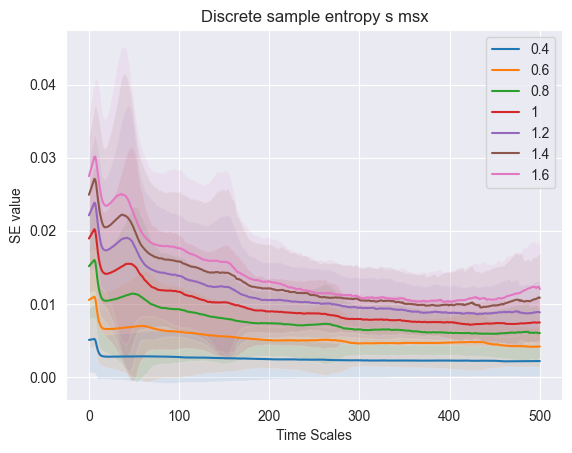

In [48]:

# %% print temporal mean and error
relevant_cols_msx=[]
relevant_cols_ci=[]
representative_msx=set()

for i in df.columns:
    if 'MSx'in i:
        relevant_cols_msx.append(i)
        representative_msx.add(i[:-len('_v_CI')])

    elif 'CI' in i:
        relevant_cols_ci.append(i)
representative_msx = {k:i for i,k in enumerate(representative_msx)}
df = df.sort_values(['key'])
datas = {}
ci_data={}
threshold=None

for m in name_order:
    datas[m]=[]
    ci_data[m]=[]
    for c in relevant_cols_msx:
        datas[m].append(np.vstack(df[df['model'] == m][c].tolist()))
    for c in relevant_cols_ci:
        ci_data[m].append(np.vstack(df[df['model'] == m][c].tolist()))

# ci_data = np.hstack(ci_data)
# indexes=np.arange(ci_data[0].shape[0])
sorted(relevant_cols_msx,key = lambda x: representative_msx[x[:-len('_v_CI')]]+int('_v_' in x))
for i,c in enumerate(relevant_cols_msx):
    if i%2==0 :
        fig, ax = plt.subplots(1,1+int(not remove_v))
    axx = ax if remove_v else ax[i%2]
    for m in name_order:
        if threshold is not None:
            mean = np.mean(datas[m][i], axis=0)
            std =  np.std(datas[m][i], axis=0)
        else:
            mean = np.mean(datas[m][i], axis=0)
            std = np.std(datas[m][i], axis=0)
        axx.plot(np.arange(datas[m][i].shape[1]), mean, label=f'{m}')
        axx.fill_between(np.arange(datas[m][i].shape[1]), mean - std, mean + std, alpha=0.1)

    axx.legend()
    # if threshold is not None:
    # ax.set_title(
    # f'Average SE Across Different Time Scales (n = {len(datas[0]) * len(datas):,}) \nCi value {"greater" if direction > 0 else "lower"} than {threshold_value:0.4}')
    # else:
    #     ax.set_title(f'Average SE Across Different Time Scales (n = {len(datas[0]) * len(datas):,})')
    axx.set_xlabel('Time Scales')
    axx.set_ylabel('SE value')
    axx.set_title(c.lower().replace('_',' ').capitalize())
    if i%2==1:
        save_large_plot(fig,f'temporal_msx_{c[:-len("_v_CI")]}_{len(d)}.png',tags=eval_name)

    fig

<h2> show traces <h2>

<h3> by input max and min <h3>

In [35]:
# models=name_order
models_to_remove = ['reduction']#,'AMPA gmax 0.0004']
# ci = 'APPROXIMATE_ENTROPY_s_CI'
# ci = 'FUZZY_ENTROPY_s_CI'
df = df.sort_values(['key'])
diff_vec = []
keys_vec = []
cur_model_order=[]
for j in tqdm(name_order):
    if j in models_to_remove:
        continue
    cur_model_order.append(j)
    keys_vec.append(df[(df['model'] == j)]['voltage'].values)
    diff_vec.append(df[(df['model'] == j)][ci].values)
diff_vec = np.array(diff_vec)
temp_diff_vec = diff_vec.copy()
a = diff_vec.sum(axis=0)
amax = np.argmax(a)
amin = np.argmin(a)
# amid =np.argwhere(a==np.percentile(a,50,method='nearest'))[0][0]
amean =(np.abs(a - a.mean())).argmin()
for i,n in enumerate(cur_model_order):
    fig,ax = plt.subplots(3)
    ax[0].plot(keys_vec[i][amax])
    ax[2].plot(keys_vec[i][amin])
    ax[1].plot(keys_vec[i][amean])

    ax[0].set_title(f'Max CI {np.round(diff_vec[i][amax],5)}')
    ax[1].set_title(f'Mean CI {np.round(diff_vec[i][amean],5)}')
    ax[2].set_title(f'Min ci {np.round(diff_vec[i][amin],5)}')
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[2].set_xlabel('Time(ms)')
    [ax[i].set_ylabel('Voltage (mv)') for i in range(3)]
    print(models[n])
    fig.suptitle(f"{models[n]} by {ci.lower().replace('_',' ').replace('CI','').capitalize()}")
    save_large_plot(fig,f'mkl_traces_{n}_{ci}.png',tags=eval_name)
    fig.tight_layout()
    fig

  0%|          | 0/4 [00:00<?, ?it/s]


KeyError: 'FUZZY_ENTROPY_s_CI'

In [50]:
models_to_remove = ['reduction']#,'AMPA gmax 0.0004']
ci = 'APPROXIMATE_ENTROPY_s_CI'
ci = 'FUZZY_ENTROPY_s_CI'

df = df.sort_values(['key'])
diff_vec = []
keys_vec = []
cur_model_order=[]
for j in name_order:
    if j in models_to_remove:
        continue
    cur_model_order.append(j)
    keys_vec.append(df[(df['model'] == j)]['voltage'].values)
    diff_vec.append(df[(df['model'] == j)][ci].values)
diff_vec = np.array(diff_vec)
temp_diff_vec = diff_vec.copy()
amax = np.argmax(diff_vec,axis=1)
amin = np.argmin(diff_vec,axis=1)
# amid =np.argwhere(a==np.percentile(a,50,method='nearest'))[0][0]
amean =(np.abs(diff_vec - diff_vec.mean(axis=1)[:,np.newaxis])).argmin(axis=1)
for i,n in enumerate(cur_model_order):
    fig,ax = plt.subplots(3)
    ax[0].plot(keys_vec[i][amax[i]])
    ax[2].plot(keys_vec[i][amin[i]])
    ax[1].plot(keys_vec[i][amean[i]])

    ax[0].set_title(f'Max CI {np.round(diff_vec[i][amax[i]],5)}')
    ax[1].set_title(f'Mean CI {np.round(diff_vec[i][amean[i]],5)}')
    ax[2].set_title(f'Min ci {np.round(diff_vec[i][amin[i]],5)}')
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[2].set_xlabel('Time(ms)')
    [ax[i].set_ylabel('Voltage (mv)') for i in range(3)]
    fig.suptitle(f"{models[n]} by {ci.lower().replace('_',' ').replace('CI','').capitalize()}")
    save_large_plot(fig,f'traces_{n}_{ci}_different_files.png',tags=eval_name)
    fig.tight_layout()
    fig

KeyError: 'FUZZY_ENTROPY_s_CI'

<h2> moments <h2>

(455, 500)
(array([0], dtype=int64),)


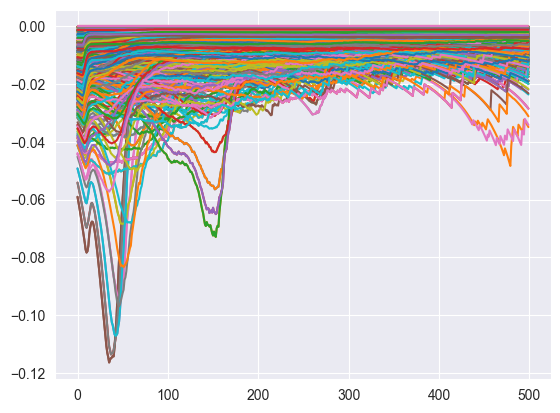

In [52]:
from scipy.stats import moment
a = df.DISCRETE_SAMPLE_ENTROPY_s_A
a=np.vstack(a)
a=np.log(a[:,1:])-np.log(a[:,:-1])
print(a.shape)
# print(a.shape)
# row = a[:,1:]/a[:,:-1]
# plt.plot(row.T)
print(np.where(np.any(a<0)))
plt.plot(a.T)